In [8]:
import pandas as pd
pd.set_option('precision', 3)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import os

import mxnet as mx
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.mx import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions

In [9]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/nbeats_TEST"
if not os.path.exists(output_path):
    if not os.path.exists("./output"):
        os.mkdir("./output")
    os.mkdir(output_path)

## Load Data From File

In [10]:
foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,1.407,...,2.841,14.296,9.429e+09,9.561e+09,6.812e+09,3.131e+08,6.227e+08,4.428e+08,606.622,608.082
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,1.405,...,-4.478,9.559,9.165e+09,9.107e+09,6.502e+09,3.834e+08,5.129e+08,3.661e+08,606.279,611.963
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,1.402,...,0.319,6.030,9.538e+09,9.025e+09,6.473e+09,6.433e+08,7.878e+08,5.644e+08,610.411,616.374
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.388,...,4.949,8.596,9.988e+09,9.341e+09,6.757e+09,5.161e+08,6.720e+08,4.863e+08,617.969,622.599
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.376,...,-2.012,4.617,9.644e+09,9.152e+09,6.618e+09,6.517e+08,6.139e+08,4.443e+08,624.767,627.842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4,1.222,...,0.381,25.366,5.134e+10,5.087e+10,4.114e+10,2.094e+09,2.165e+09,1.761e+09,4267.526,4315.057
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8,1.252,...,-0.063,16.739,5.172e+10,5.162e+10,4.110e+10,8.183e+08,1.866e+09,1.484e+09,4295.341,4330.297
2021-08-01,158.5,148.3,146.8,165.9,158.0,142.5,182.1,141.7,152.2,1.259,...,-2.861,11.774,5.166e+10,5.043e+10,3.993e+10,1.425e+09,2.484e+09,1.967e+09,4330.822,4351.796
2021-09-01,158.1,148.0,147.1,165.9,158.5,141.5,184.8,144.3,150.0,1.267,...,-3.461,8.557,5.080e+10,4.965e+10,3.920e+10,1.561e+09,2.277e+09,1.798e+09,4346.662,4367.402


## Experiment And Data Setup

In [11]:
report_sim_dates = pd.read_csv("./reportsimdates.txt", sep='\n', header=None)[0].to_list()
report_sim_dates

['2015-07-01',
 '2016-07-01',
 '2017-07-01',
 '2018-07-01',
 '2019-07-01',
 '2020-07-01']

In [12]:
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

In [13]:
dataset_df = foodprice_df[foodprice_categories].T
dataset_df

,1986-01-01,1986-02-01,1986-03-01,1986-04-01,1986-05-01,1986-06-01,1986-07-01,1986-08-01,1986-09-01,1986-10-01,...,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01
Bakery and cereal products (excluding baby food),69.3,70.3,70.6,71.3,71.2,71.1,71.7,71.9,71.7,71.1,...,154.2,157.1,156.8,156.2,157.8,157.7,157.9,158.5,158.1,159.3
Dairy products and eggs,70.9,70.8,71.1,71.0,71.4,71.1,71.3,71.5,71.8,71.8,...,141.6,143.1,144.9,146.1,146.6,145.3,146.4,148.3,148.0,146.6
"Fish, seafood and other marine products",60.6,61.3,61.3,61.4,61.9,62.0,62.2,62.7,63.1,63.6,...,143.4,143.9,144.9,145.1,147.6,146.2,146.6,146.8,147.1,149.3
Food purchased from restaurants,59.1,59.1,59.3,59.7,59.9,60.0,60.6,60.9,60.9,61.3,...,162.6,162.9,162.6,163.2,163.5,163.9,165.2,165.9,165.9,167.1
Food,67.3,66.9,67.0,67.7,68.2,68.4,69.2,69.5,69.9,70.2,...,155.0,155.6,155.5,155.4,156.6,156.8,157.6,158.0,158.5,159.2
"Fruit, fruit preparations and nuts",76.0,77.6,79.2,82.2,83.5,83.1,84.8,86.7,83.8,82.9,...,140.9,143.4,142.4,141.9,143.9,144.5,141.7,142.5,141.5,141.7
Meat,65.1,64.2,64.2,63.6,64.0,64.9,66.5,67.8,71.3,71.5,...,171.9,169.5,170.2,173.5,175.4,176.7,180.9,182.1,184.8,187.1
Other food products and non-alcoholic beverages,77.5,78.1,78.6,79.5,79.8,79.9,80.2,80.2,80.8,81.0,...,139.0,139.5,141.5,140.5,141.6,142.2,141.9,141.7,144.3,144.4
Vegetables and vegetable preparations,76.0,68.4,66.2,71.1,75.3,74.1,75.7,71.9,66.6,70.7,...,162.5,163.8,157.4,151.1,153.8,153.4,154.8,152.2,150.0,149.4


In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', 'index':'ds', food_category:'y'}, axis=1)
    return df

## Fit Models and Save Forecasts

Fit a model using data up to the `report_sim_date` and use it to produce forecasts for the following 18 months. Collect evaluation metrics for comparion and save the forecasts for use in the ensembling experiments.

In [15]:
def train_eval_nbeats(report_sim_date, prediction_length=18):

    report_train_dates = sim_train_dates[report_sim_date]
    report_valid_dates = sim_valid_dates[report_sim_date]
    
    # train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
    train_ds = ListDataset(
        [{'target': x, 'start': report_sim_date} for x in dataset_df[list(report_train_dates)].values],
        freq='MS'
    )

    valid_ds_report = ListDataset(
        [{'target': x, 'start': report_sim_date} for x in dataset_df[list(report_train_dates) + list(report_valid_dates)].values],
        freq='MS'
    )

    estimator = NBEATSEnsembleEstimator(
        prediction_length=prediction_length,
        meta_bagging_size = 3,
        meta_context_length = [prediction_length * m for m in [3,5,7]], 
        meta_loss_function = ['sMAPE'], 
        num_stacks = 30,
        widths= [512],
        freq="MS",
        trainer=Trainer(
                    epochs=1,  # 50
                    ctx=mx.context.cpu()
                )

    )

    predictor = estimator.train(train_ds)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=valid_ds_report,  # test dataset
        predictor=predictor,  # predictor
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    all_fc_dates = list(report_train_dates) + list(report_valid_dates)

    all_food_metrics = {}
    food_forecasts = {}

    for target_index in range(len(forecasts)):

        # Get food price category
        foodprice_category = foodprice_df.columns[target_index]

        # plot actual
        fig, ax = plt.subplots(figsize=(8,3))
        ax.scatter(all_fc_dates, foodprice_df[foodprice_category][all_fc_dates], color='black')

        # plot forecast
        forecast_entry = forecasts[target_index]
        ax.plot(report_valid_dates, forecast_entry.mean[:len(report_valid_dates)], color='C0')

        plt.title(f"{foodprice_category}, {report_sim_date}")
        plt.grid()
        plt.show()

        fc_metrics = {}
        for metric_name, metric_fn in metrics.items():
            print(metric_name, metric_fn)
            y_true = foodprice_df[foodprice_category][report_valid_dates]
            y_pred = forecast_entry.mean[:len(report_valid_dates)]
            score = metric_fn(y_true=y_true, y_pred=y_pred)
            print(metric_name, score)
            fc_metrics[metric_name] = score


        all_food_metrics[foodprice_category] = fc_metrics
        food_forecasts[foodprice_category] = pd.Series(forecast_entry.mean[:len(report_valid_dates)], index=report_valid_dates, name=foodprice_category)


    all_forecasts = pd.DataFrame(food_forecasts)
    all_forecasts.to_csv(f"{output_path}/forecasts_{report_sim_date}.csv")

    return all_food_metrics, all_forecasts

/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)


TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=1, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be remo

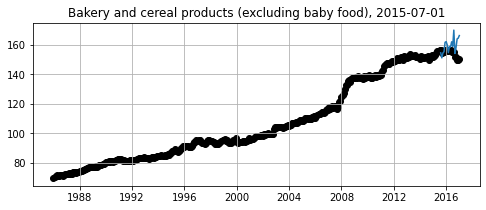

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -9.474114438907257
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.806770324707031
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03799935561904619
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 60.53165302818487
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.780209060699132


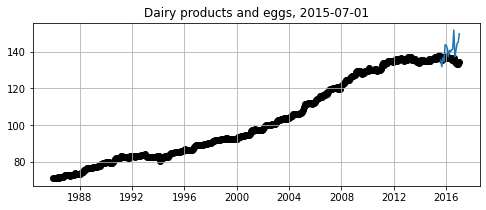

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -32.93758917469982
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 6.050227016872834
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.04469905272052731
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 57.12827511074493
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.558324887879915


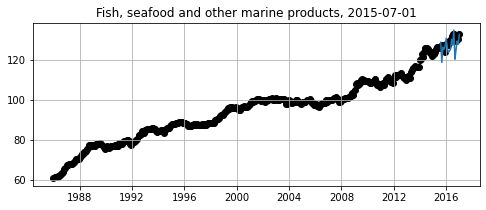

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -1.853628060400867
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.443532901340061
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.026556903500603475
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 20.51908302826458
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.529799446803862


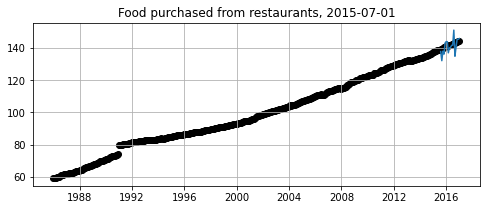

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -5.76796125023507
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.122879367404514
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.022028989285059322
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 15.374343085757763
rmse <function rmse at 0x7fbbd5b0d430>
rmse 3.9210130178000893


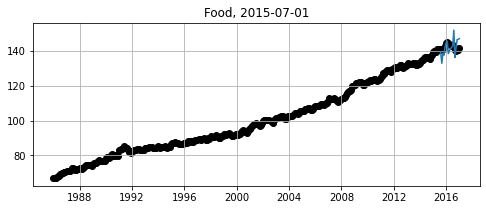

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -6.571218435362822
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.462062072753909
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.024429469328619793
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 19.274826587113154
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.3903105342462


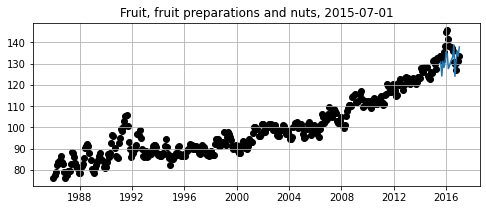

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -0.9964585417653666
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 6.3253582424587655
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.046209820562877216
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 50.93532635678764
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.136898931383829


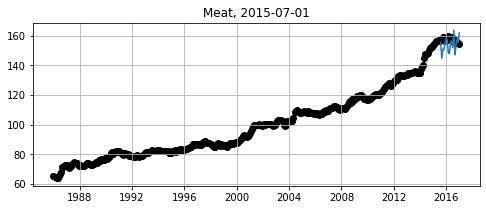

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -18.570383825055945
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.306778971354165
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03365218156106191
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 44.42235518610827
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.665009766392565


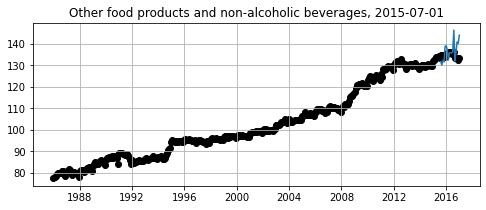

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -16.279353867448478
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.823668077256945
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.028490821033541208
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 24.756940922247647
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.975634725564935


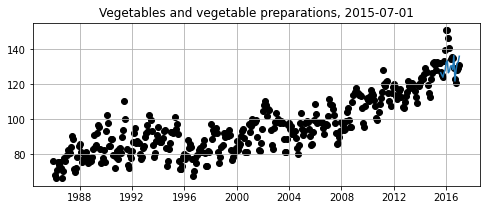

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -0.15797349677220707
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 7.307548946804467
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.0523212403953322
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 91.14212823518972
rmse <function rmse at 0x7fbbd5b0d430>
rmse 9.546838651364634
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=1, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/h/ethanj

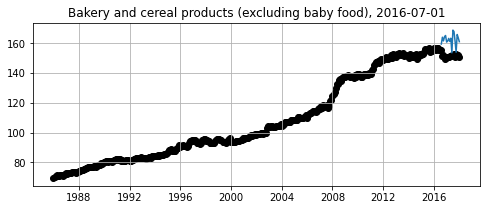

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -75.90686132464353
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 10.615620930989584
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.0701613297071543
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 130.84610566850856
rmse <function rmse at 0x7fbbd5b0d430>
rmse 11.438798261553027


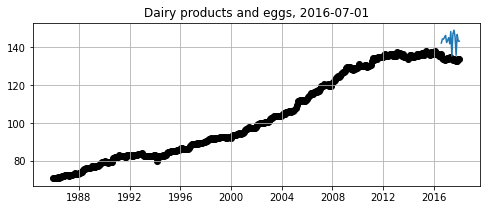

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -151.79432085330686
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 9.938182237413196
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.07423227506534452
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 111.91712415094594
rmse <function rmse at 0x7fbbd5b0d430>
rmse 10.579089003829486


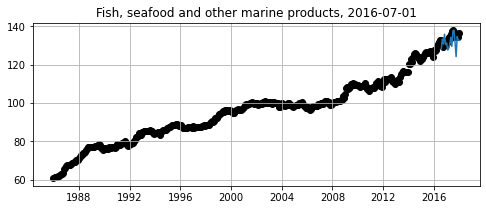

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -1.9624740061261634
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.2385667588975715
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.024103597370339142
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 17.990354877264373
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.241503846192336


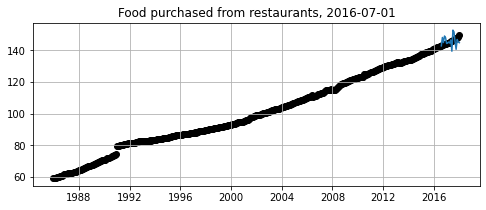

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -3.1571033780604854
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 2.9547773573133673
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.020228975109630388
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 14.532540559136404
rmse <function rmse at 0x7fbbd5b0d430>
rmse 3.8121569431407734


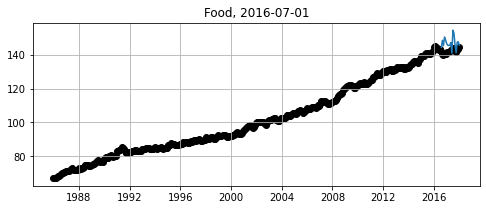

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -18.4465488546067
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.033641899956597
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03543491172770721
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 33.84239682614184
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.817421836702392


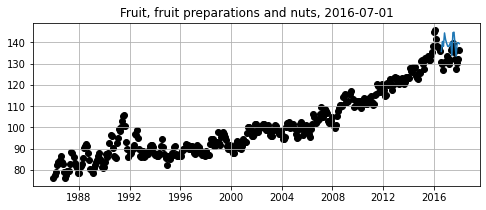

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -4.600458345664161
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 7.298778618706598
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.05544373050795212
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 61.37635641985779
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.834306377711928


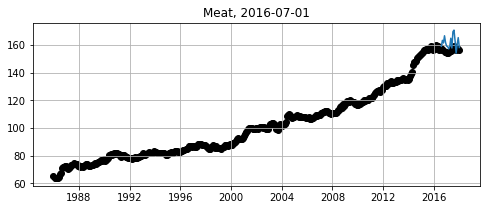

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -18.791490195733555
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.492768181694877
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.035074774509573
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 41.76493110070053
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.462579291637398


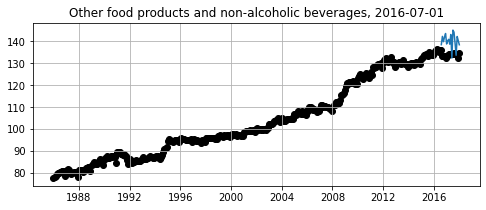

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -70.41395485569586
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 6.460621812608502
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.048315317201797374
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 50.5826805550418
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.112150206164223


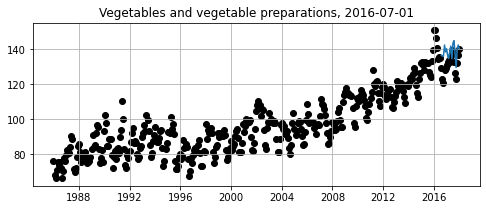

/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)


r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -1.5315640417297272
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 7.665557013617619
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.059426875193091075
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 76.2550844796876
rmse <function rmse at 0x7fbbd5b0d430>
rmse 8.732415729893281
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=1, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be remo

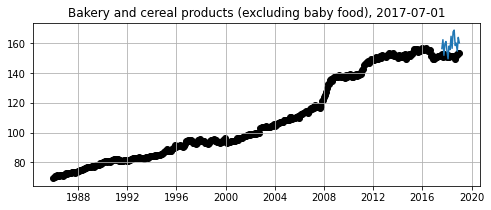

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -76.69125197216512
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 7.721252102322048
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.05088769383857776
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 80.35049883750884
rmse <function rmse at 0x7fbbd5b0d430>
rmse 8.963843976637971


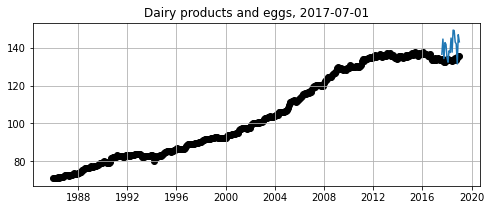

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -103.97006061449677
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 7.31960940890842
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.054633053352289754
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 74.1788428342441
rmse <function rmse at 0x7fbbd5b0d430>
rmse 8.612714022550852


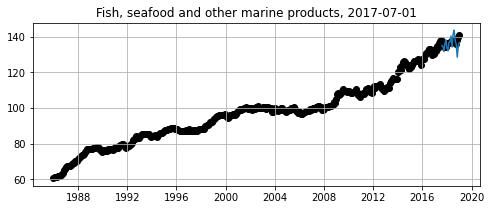

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -4.241808292946703
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.053170267740888
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.02221637284523061
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 14.124570154805896
rmse <function rmse at 0x7fbbd5b0d430>
rmse 3.758266908404178


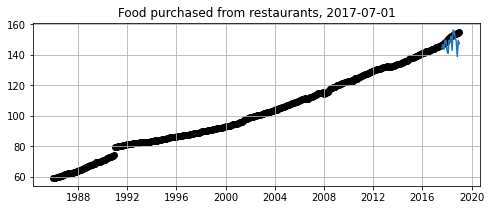

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -4.08760462409012
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.493038770887588
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.029545015115521236
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 35.196174409322765
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.9326363793277235


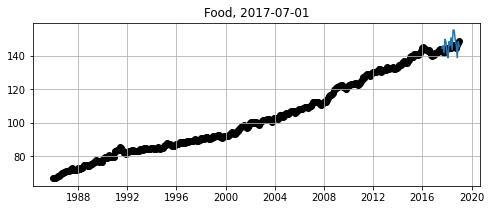

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -7.755722698927174
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.151588948567705
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.028634606982808446
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 24.603580783985322
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.960199671785937


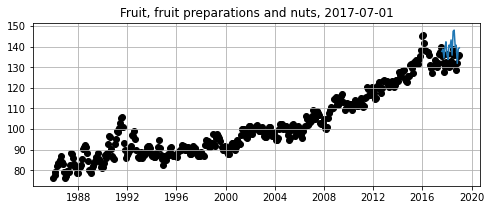

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -5.557449418987346
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 6.366648186577692
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.04814842620994099
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 57.68470867442951
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.5950450080581815


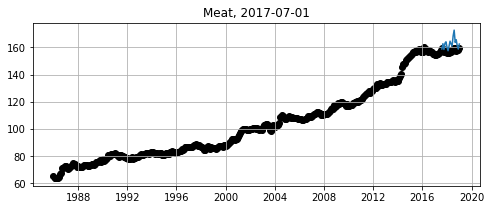

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -21.15999547988608
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.677623494466147
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.029595948932180927
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 32.13541319822378
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.668810562915627


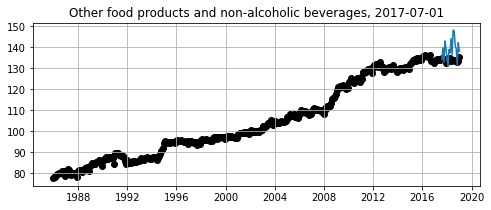

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -100.93819129386429
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.67782609727647
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.042450317443149505
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 49.85218027936029
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.060607642360556


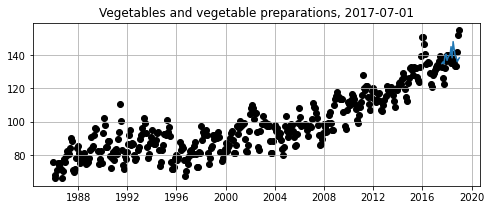

/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)


r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -0.1411051257461826
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 6.620846218532988
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.04797729342091491
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 62.44792892739801
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.902400200407342
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=1, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be remo

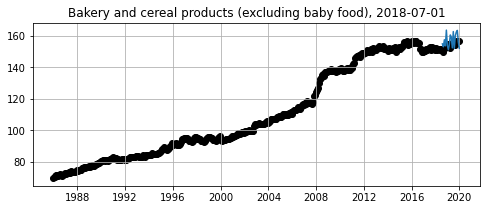

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -5.528303596346836
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.343089124891495
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.028127696111320474
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 26.06969236141175
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.1058488384804095


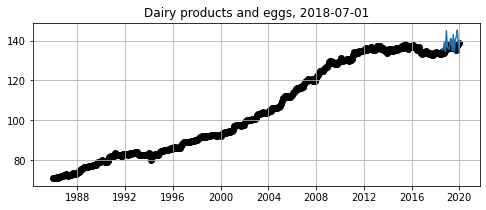

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -7.427608618810773
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.40145992702908
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.024920559499165947
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 18.59276123680849
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.3119324248889255


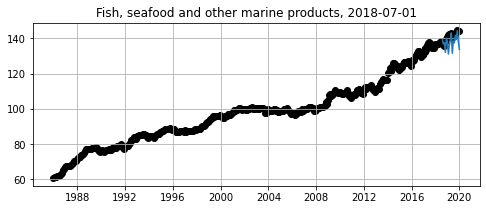

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -3.116976000319223
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.88706495496962
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.027427453269310714
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 27.007362562094094
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.196860837283801


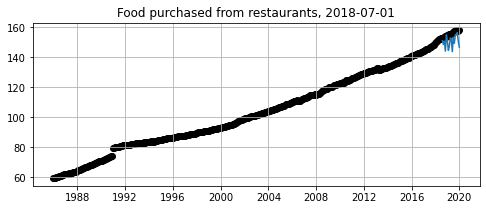

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -13.127181732944935
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.442875332302517
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03489784328498061
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 42.20190325828011
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.496299197102926


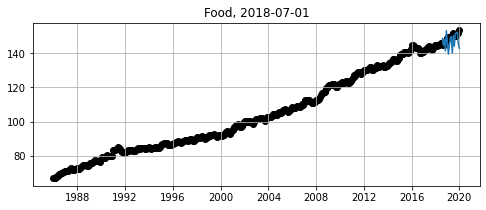

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -3.942484051590732
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.122863091362847
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.02751509130777533
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 29.13762148797202
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.397927517850904


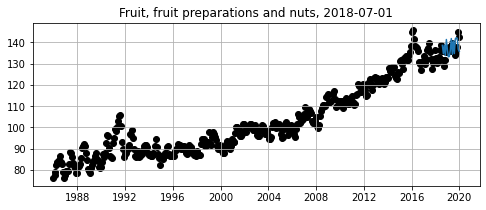

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -1.1409756384793472
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.581082322862413
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.033620282885762735
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 28.27548199632567
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.317469510615521


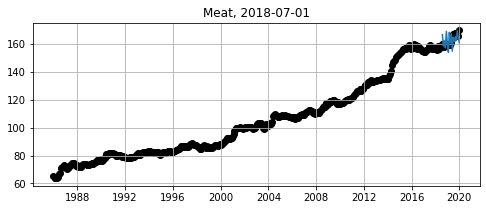

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -0.9102128126337383
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.75019734700521
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.029225242922172434
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 32.5066338386956
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.701458921951082


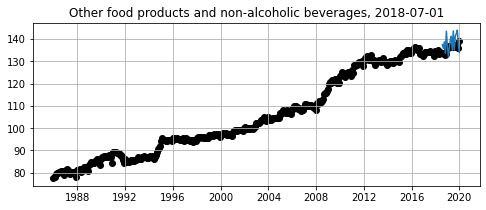

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -7.020742774933373
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.866419982910156
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.02847718151860567
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 21.130201243741112
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.596759863614926


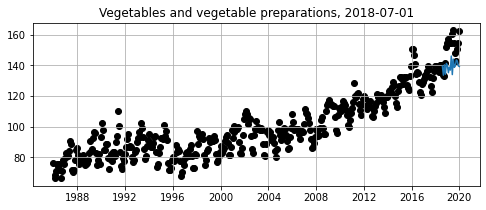

/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)


r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -1.5797158892705534
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 12.529810418023008
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.0808474132808947
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 212.61102719468948
rmse <function rmse at 0x7fbbd5b0d430>
rmse 14.581187441175341
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=1, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be remo

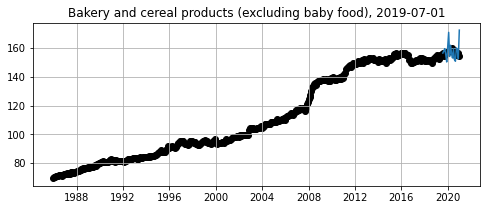

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -14.825008111185888
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.162746005588111
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03294758664628867
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 43.37468658376127
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.585946141881307


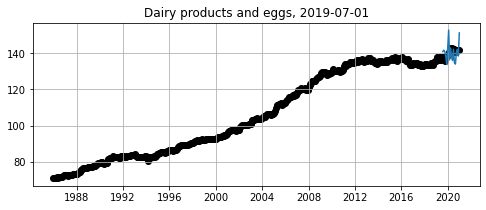

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -5.79157860468459
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.258819749620228
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.030358137874535316
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 28.573470812974424
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.3454158690390425


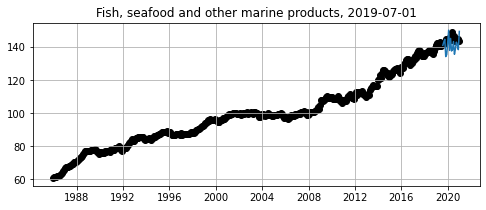

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -14.207537021605107
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.088945515950517
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03501864641117518
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 39.62408257295996
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.294766284220564


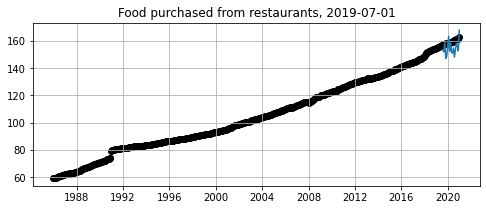

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -16.954089952252325
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 6.061982218424477
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.0379835365318371
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 46.995938727177865
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.855358395239294


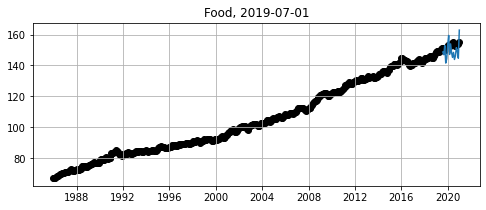

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -16.041125087178308
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.522225782606338
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03605336703384656
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 39.91883551671534
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.3181354462147565


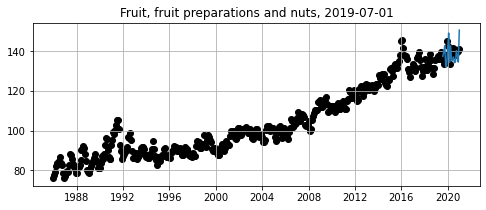

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -3.286137636185786
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.9128367106119795
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.035309337556481676
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 36.265486777283044
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.022083258913234


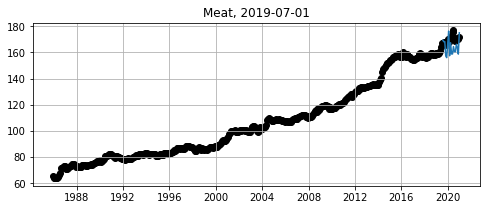

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -9.44115421778038
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 7.652336120605467
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.044723260426100656
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 83.11416563630158
rmse <function rmse at 0x7fbbd5b0d430>
rmse 9.116697079332052


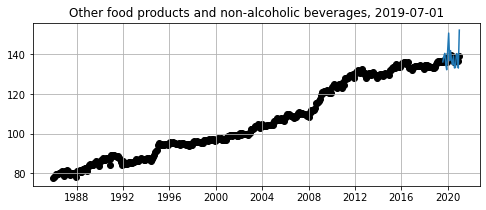

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -19.08333070685622
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.5781967163085935
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.025948217390711386
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 24.692579075256877
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.969162814323644


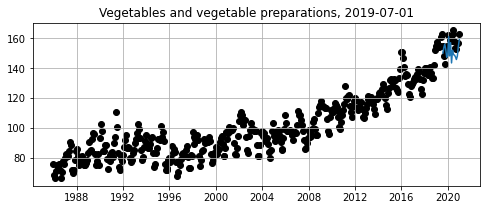

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -1.6480118945733766
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 7.851159667968754
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.050016661356251074
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 83.30612728822985
rmse <function rmse at 0x7fbbd5b0d430>
rmse 9.127219033650384
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=1, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)
  0%|          | 0/50 [00:00<?, ?it/s]/h/ethanj/.conda/envs/foodprice_forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/h/ethanj

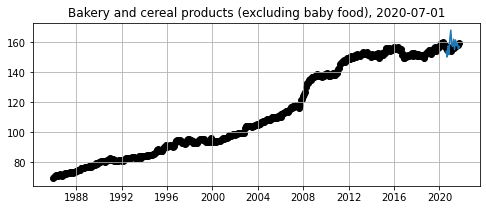

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -11.871041776068182
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.4977520751953155
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.022407099157900914
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 23.36008275411219
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.833226950404066


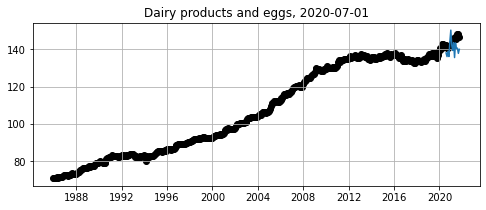

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -4.466462099263939
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.367839965820314
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03703989776703402
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 37.81917138754765
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.149729375147142


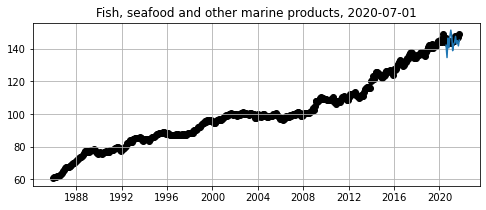

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -6.813747473531737
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 4.2195845540364605
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.02903860762241099
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 21.989621778845798
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.689309307227004


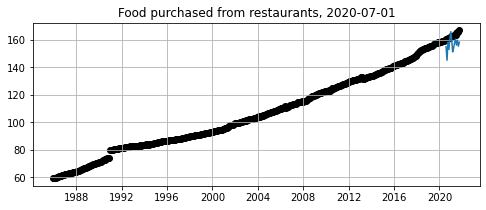

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -16.423487014177198
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 7.014463704427082
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.04293643290371087
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 63.4787966444517
rmse <function rmse at 0x7fbbd5b0d430>
rmse 7.967358197323106


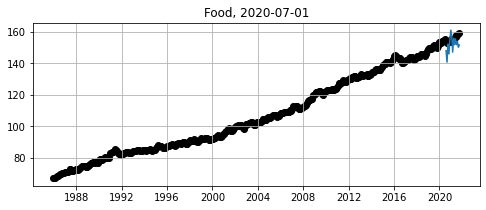

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -8.685970905326824
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.131366170247397
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.03295305813417062
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 37.626337822630376
rmse <function rmse at 0x7fbbd5b0d430>
rmse 6.134031123382924


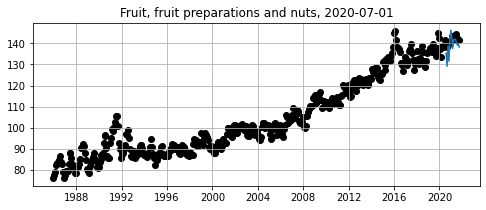

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -5.792910764403534
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.364898681640625
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.023898633568007584
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 18.095106647790708
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.253834346538509


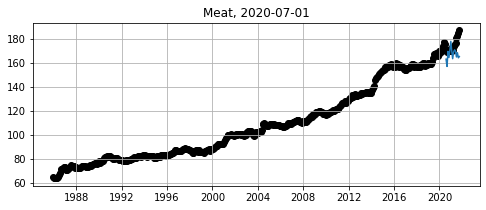

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -2.42471087186863
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 8.585758056640625
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.04811159299424529
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 118.69347718785086
rmse <function rmse at 0x7fbbd5b0d430>
rmse 10.894653605684343


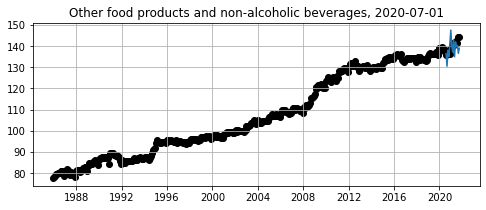

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -2.0170089715063546
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 3.6322660319010405
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.025862368395742834
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 20.70660415181767
rmse <function rmse at 0x7fbbd5b0d430>
rmse 4.550450983344142


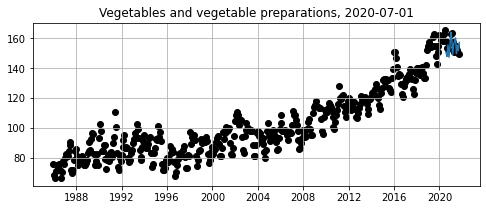

r2_score <function r2_score at 0x7fbbec9c0af0>
r2_score -0.9071813745100314
mae <function mean_absolute_error at 0x7fbbec9b5a60>
mae 5.0596317545572935
mape <function mean_absolute_percentage_error at 0x7fbbec9c0820>
mape 0.032643561506185116
mse <function mean_squared_error at 0x7fbbec9c08b0>
mse 31.53833789953096
rmse <function rmse at 0x7fbbd5b0d430>
rmse 5.615900453135807


In [16]:
all_valid_metrics = {}
all_forecasts = {}

for report_sim_date in report_sim_dates:
    valid_metrics, forecasts = train_eval_nbeats(report_sim_date)
    all_valid_metrics[report_sim_date] = valid_metrics
    all_forecasts[report_sim_date] = forecasts

In [17]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
mean_scores.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_scores

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-32.383,6.191,0.040,60.755,7.451
Dairy products and eggs,-51.065,6.056,0.044,54.702,7.093
"Fish, seafood and other marine products",-5.366,3.822,0.027,23.543,4.785
Food purchased from restaurants,-9.920,4.848,0.031,36.297,5.831
Food,-10.241,4.571,0.031,30.734,5.503
"Fruit, fruit preparations and nuts",-3.562,5.475,0.040,42.105,6.360
Meat,-11.883,6.078,0.037,58.773,7.418
Other food products and non-alcoholic beverages,-35.959,4.506,0.033,31.954,5.544
Vegetables and vegetable preparations,-0.994,7.839,0.054,92.883,9.251
